In [1]:
from keras import backend as K

C:\Users\Jhansi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.utils import np_utils
import pandas as pd
import numpy as np
import random

In [3]:
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense , GlobalAveragePooling2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Get the data

In [4]:
train_path = 'imgs/train_1/train'
valid_path = 'imgs/train_1/validation'
test_path = 'imgs/test_imgs'
batch_size = 8
test_batch_size = 32

### Import the data batch wise using generator to save the memory usage

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
#test_gen = ImageDataGenerator(rescale=1./255)
train_batch = datagen.flow_from_directory(train_path, target_size= (224,224), classes=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'],batch_size= batch_size,shuffle= False)
validation_batch = datagen.flow_from_directory(valid_path, target_size= (224,224), classes=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'],batch_size= batch_size,shuffle= False)
test_batch = datagen.flow_from_directory(test_path, target_size= (224,224),batch_size= test_batch_size,shuffle= False)

Found 17976 images belonging to 10 classes.
Found 4448 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


### Pre trained Model

In [6]:
base_model = VGG16(include_top=False, weights='imagenet')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Save the bottle neck features using pre trained model

In [7]:
bottleneck_features_train_VGG16 = base_model.predict_generator(train_batch)

In [8]:
np.save(open('bottleneck_features/bottleneck_features_train_VGG16_generator.npy', 'wb'),bottleneck_features_train_VGG16)

In [9]:
bottleneck_features_valid_VGG16 = base_model.predict_generator(validation_batch)
np.save(open('bottleneck_features/bottleneck_features_valid_VGG16_generator.npy', 'wb'),bottleneck_features_valid_VGG16)

In [10]:
#bottleneck_features_test_VGG16 = base_model.predict_generator(test_batch)
#np.save(open('bottleneck_features/bottleneck_features_test_VGG16_generator_trail.npy', 'wb'),bottleneck_features_test_VGG16)

In [11]:
print(bottleneck_features_train_VGG16.shape)
print(bottleneck_features_valid_VGG16.shape)
#print(bottleneck_features_test_VGG16.shape)

(17976, 7, 7, 512)
(4448, 7, 7, 512)


### Load the features as train and validation data

In [12]:
train_data = np.load('bottleneck_features/bottleneck_features_train_VGG16_generator_trail.npy')

In [13]:
validation_data = np.load('bottleneck_features/bottleneck_features_valid_VGG16_generator_trail.npy')

### Get label information from generator batch

In [14]:
train_labels = []
for i in range(0,int(len(train_batch.filenames)/batch_size)):
    train_labels.extend(np.array(train_batch[i][1]))

In [15]:
valid_labels = []
for i in range(0,int(len(validation_batch.filenames)/batch_size)):
    valid_labels.extend(np.array(validation_batch[i][1]))

In [16]:
validation_batch.filenames[3000]

'c6\\img_62810.jpg'

In [17]:
valid_labels[3000]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### Convert the labels as arrays

In [18]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

In [19]:
# model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
# #model.add(Dense(64, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(Dense(94, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(Dense(94, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

# model.compile(optimizers.rmsprop(lr= 0.000014),loss='categorical_crossentropy', metrics=['accuracy'])

# checkpointer = ModelCheckpoint(filepath='saved_models/bottleneck_fc_model_test.hdf5', 
#                                verbose=1, save_best_only=True)

# earlystop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

### Build a Sequential Model

In [20]:
from keras.layers.normalization import BatchNormalization

In [21]:
model = Sequential()
model.add(MaxPool2D(input_shape=train_data.shape[1:]))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(10, activation='softmax'))

model.compile(optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/bottleneck_fc_model_test_fast.ai.hdf5', 
                               verbose=1, save_best_only=True)

earlystop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

### Train the Model

In [22]:
history =model.fit(train_data, train_labels,epochs=50, batch_size=batch_size,
              validation_data=(validation_data, valid_labels), callbacks = [checkpointer,earlystop] )
score = model.evaluate(validation_data, valid_labels, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Train on 17976 samples, validate on 4448 samples
Epoch 1/50
17976/17976 [==============================] - 30s 2ms/step - loss: 2.0206 - acc: 0.4053 - val_loss: 1.0480 - val_acc: 0.6630

Epoch 00001: val_loss improved from inf to 1.04804, saving model to saved_models/bottleneck_fc_model_test_fast.ai.hdf5
Epoch 2/50
17976/17976 [==============================] - 33s 2ms/step - loss: 0.8680 - acc: 0.7113 - val_loss: 0.8321 - val_acc: 0.7345

Epoch 00002: val_loss improved from 1.04804 to 0.83211, saving model to saved_models/bottleneck_fc_model_test_fast.ai.hdf5
Epoch 3/50
17976/17976 [==============================] - 31s 2ms/step - loss: 0.6842 - acc: 0.7821 - val_loss: 0.8407 - val_acc: 0.7228

Epoch 00003: val_loss did not improve from 0.83211
Epoch 4/50
17976/17976 [==============================] - 29s 2ms/step - loss: 0.5651 - acc: 0.8185 - val_loss: 0.8761 - val_acc: 0.7026

Epoch 00004: val_loss did not improve from 0.83211
Epoch 5/50
17976/17976 [==============================]

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [24]:
epoch = np.arange(len(acc))

In [25]:
import matplotlib.pyplot as plt

[Text(0,0.5,'Loss'), Text(0.5,0,'Epochs')]

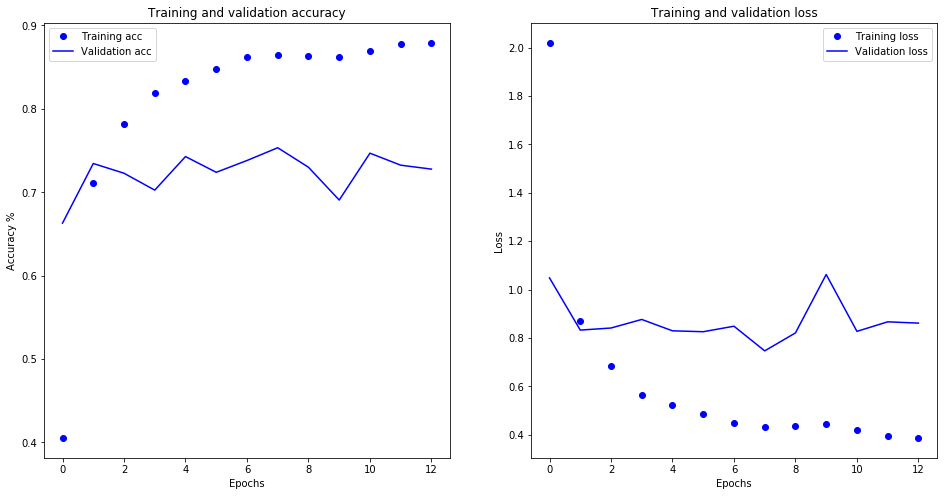

In [26]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(epoch, acc, 'bo', label='Training acc')
axes[0].plot(epoch, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Accuracy %')
axes[1].plot(epoch, loss, 'bo', label='Training loss')
axes[1].plot(epoch, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()
axes[1].set(xlabel='Epochs', ylabel='Loss')
#plt.savefig('Evaluation_grapgh.png')

### Load the best model weights

In [28]:
path_best_model = '19_best_model.keras' # got this from scikit optimizer

In [29]:
from keras.models import load_model

In [30]:
best_model = load_model(path_best_model)

In [31]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 94)                2358366   
_________________________________________________________________
layer_dense_2 (Dense)        (None, 94)                8930      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                950       
Total params: 2,368,246
Trainable params: 2,368,246
Non-trainable params: 0
_________________________________________________________________


### Validate the Model using validation data

In [32]:
result = best_model.evaluate(validation_data,valid_labels)

4448/4448 [==============================] - 1s 181us/step


In [33]:
y_pred = best_model.predict(validation_data)

In [34]:
np.argmax(y_pred,axis=1)

array([9, 0, 0, ..., 9, 9, 9], dtype=int64)

In [35]:
np.argmax(valid_labels,axis = 1)

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

In [37]:
precision_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='macro')

0.7933910680142102

In [38]:
precision_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='micro')

0.770908273381295

In [39]:
precision_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='weighted')

0.7967270928511695

In [40]:
recall_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='macro')

0.7689667717722533

In [41]:
recall_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='micro')

0.770908273381295

In [42]:
recall_score(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1),average='weighted')

0.770908273381295

In [43]:
confusion_matrix(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1))

array([[408,   1,   0,   5,   0,   0,   2,   0,   4, 104],
       [  8, 406,   0,   0,   0,   0,   1,   2,   0,  13],
       [  2,  43, 284,   0,   0,   0,   3,  27,  33,  43],
       [  1,   0,   0, 405,  48,   0,   1,   0,   2,   9],
       [  5,   0,   0,  17, 309,   0,   0,   0, 102,   7],
       [  8,   0,   0,   0,   0, 346,   0,   0,  84,   9],
       [  0,  31,   0,   0,   0,   0, 410,   3,  13,   3],
       [  0,  34,   0,   1,   0,   0,   0, 375,   5,   0],
       [ 12,  48,   9,   1,   9,   0,  19,  36, 256,  10],
       [128,  42,   0,   3,   0,   4,   0,   4,  20, 230]], dtype=int64)

In [44]:
accuracy_score(np.argmax(valid_labels, axis=1), np.argmax(y_pred, axis=1))

0.770908273381295

### Use Model to predict test data

In [45]:
filenames = []
VGG16_predictions = []
for i,batch in enumerate(test_batch):
    filenames += test_batch.filenames[i*test_batch_size: (i+1) * test_batch_size]
    bottleneck_features_test_VGG16 = np.asarray([base_model.predict(batch[0])],dtype=np.float32)
    s1,s2,s3,s4,s5 = bottleneck_features_test_VGG16.shape
    bottleneck_features_test_VGG16 = bottleneck_features_test_VGG16.reshape(s2,s3,s4,s5)
    VGG16_predictions += [best_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]    
    if (i+1) * test_batch_size >= len(test_batch.filenames):
        break
    #print(i)

In [46]:
len(VGG16_predictions)

79726

In [47]:
len(filenames)

79726

In [48]:
filenames[0]

'test\\img_1.jpg'

In [49]:
np.round_(VGG16_predictions[0],decimals =3, out= None)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

### Save the results

In [50]:
test_files_final = [item_test.replace('test\\','') for item_test in filenames]

In [51]:
VGG16_subm = np.column_stack((np.asarray(test_files_final), np.asarray(np.round_(VGG16_predictions,decimals =3, out= None),dtype=np.float32)))

In [55]:
np.savetxt('kaggle_submissions/VGG16_submission_optimized.csv',VGG16_subm, delimiter=',',comments='', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')

## Scikit optimizer
To get the best hyper parameters for the model

In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install h5py scikit-optimize

In [ ]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
tf.keras.__version__

In [ ]:
skopt.__version__

In [ ]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

In [ ]:
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

In [ ]:
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')

In [ ]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes]

In [ ]:
default_parameters = [1e-5, 1, 32]

In [ ]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes)

    return log_dir

In [ ]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [ ]:
import keras.backend as K

In [ ]:
import tensorflow as tf

from keras import backend as K


In [ ]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()
# This below commented code not required for me 
#     # Add an input layer which is similar to a feed_dict in TensorFlow.
#     # Note that the input-shape must be a tuple containing the image-size.
#     model.add(InputLayer(input_shape=(img_size_flat,)))

#     # The input from MNIST is a flattened array with 784 elements,
#     # but the convolutional layers expect images with shape (28, 28, 1)
#     model.add(Reshape(img_shape_full))

#     # First convolutional layer.
#     # There are many hyper-parameters in this layer, but we only
#     # want to optimize the activation-function in this example.
#     model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
#                      activation=activation, name='layer_conv1'))
#     model.add(MaxPooling2D(pool_size=2, strides=2))

#     # Second convolutional layer.
#     # Again, we only want to optimize the activation-function here.
#     model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
#                      activation=activation, name='layer_conv2'))
#     model.add(MaxPooling2D(pool_size=2, strides=2))
# upto here
    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten(input_shape= train_data.shape[1:]))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation='relu',
                        name=name))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    
    return model

In [ ]:
path_best_model = '19_best_model.keras'

In [ ]:
best_accuracy = 0.0

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    #print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.

    history = model.fit(x=train_data, y=train_labels,epochs=20, batch_size=batch_size,
              validation_data=validation_data_opt,callbacks=[callback_log])
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [ ]:
fitness(x=default_parameters)

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=40,
                            acq_func='EI', # Expected Improvement.                            
                            x0=default_parameters)

In [ ]:
plot_convergence(search_result)

In [ ]:
search_result.x

In [ ]:
search_result.fun

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))

In [ ]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

In [ ]:
fig, ax = plot_objective(result=search_result, dimensions= dim_names)

In [ ]:
best_model = load_model(path_best_model)

In [ ]:
validation_data.shape

In [ ]:
result = best_model.evaluate(validation_data,valid_labels)

In [ ]:
for name, value in zip(best_model.metrics_names, result):
    print(name, value)

In [ ]:
y_pred = best_model.predict(validation_data)

In [ ]:
np.argmax(y_pred,axis=1)

In [ ]:
np.argmax(valid_labels,axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
confusion_matrix(np.argmax(valid_labels,axis = 1),np.argmax(y_pred,axis=1))

In [ ]:
accuracy_score(np.argmax(valid_labels, axis=1), np.argmax(y_pred, axis=1))